In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import pickle
import fnmatch
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

from survive import datasets
from survive import SurvivalData
from survive import KaplanMeier, Breslow, NelsonAalen
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

from pprint import pprint
pd.set_option('display.width', None)
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

# KM Functions

In [65]:
def generate_kaplan_meier_for_status(survival_type="OS", years=10, save_to_csv_filename = "None"):
    
    """
    This is the main Kaplan Meier Function to generate a chart and DF with an option to save the DF as csv. 
    """
    
    # Building Base df_dict
    listToDrop = ['NRIC','dob','Has Bills?','Side','Hospital','KKH','NCCS','SGH','END_OF_ENTRY']
    clinical = dataSetting(listToDrop)
    print(clinical.shape)

    year_list = list([1,5,10])
    df_dict = ComputeYears(clinical,year_list)

#    Display shape of data after filtering
#     for i in df_dict: 
#         for s_type in df_dict[i]:
#             print("Year: {}, survival category: {}, size: {}".format(i,s_type,df_dict[i][s_type].shape[0]))

    #Build Input DF
    surv = build_surv_obj(survival_type=survival_type, years=years, df_dict=df_dict)
    km = KaplanMeier()
    km.fit(surv)

    #Plot Curve
    plt.figure(figsize=(10, 6))
    km.plot()
    plt.show()
    plt.close()
    
    #Show KM df
    output_df = KM_to_df(km)
    display(output_df.head())
    
    #if csv filename given, save as filename else, end function
    if save_to_csv_filename == "None":
        #End of function
        return
        
    else: 
        output_df.to_csv(save_to_csv_filename)
        

def build_surv_obj(survival_type, years, df_dict):
    
    """
    This function builds the survival object to be processed by kaplan meier model to return kaplan meier df
    """
    
    survival_type = str(survival_type)
    years = str(years)
    
    survival_df = df_dict[years + "_years"][survival_type]
    
    Time_df = survival_df.loc[:,[survival_type + "_days"]]
    Time_df[survival_type + "_years"] = Time_df[survival_type + "_days"]/365.25
    Time_df["status"] = survival_df["Count_as_" + survival_type].apply(lambda status: 0 if status in "nN" else 1)
    Time_df["check"] = survival_df["Count_as_" + survival_type]
    
#     display(Time_df)

    return SurvivalData(time= (survival_type+ "_years"), status="status", data=Time_df)

def KM_to_df(KM_object):
    
    # Process the summary as string
    
    summary_lines_list = str(KM_object.summary).split("\n")
    
    header = ["time", "events", "at_risk",  "estimate",  "std_error",  "95%_CI_lower",  "95%_CI_upper"]
    rows = summary_lines_list[6:]
    
    row_values = []
    
    for row in rows:
        
        elements = row.split(" ")
        tmp = []
        for element in elements:
            if element.isnumeric() or ("." in element):
                tmp.append(element)
                
        row_values.append(tmp)
        
    #Build df
    output_df = pd.DataFrame(row_values, columns=header)
                
    return output_df



# Data Processing Functions

In [66]:
def drop_by_index(X,indexes):
    """
    helper function to drop rows of dataframe and return new dataframe without those rows with indexes resetted
    """
    X = X.drop(indexes)
    X = X.reset_index().drop(columns="index")
    return(X)

def dataSetting(dropCol,FILE_FOLDER = "C:\\SMU_v2\\"):
    '''
    function to read the pkl from from datasource
        1. Remove dx_date that is NULL.
        2. Drop all rows where crucial fields for X_features are NULL.
        3. Convert Date columns into datetime format
        4. Derive OS, CSS, DFS days based on dx_date
        5. Create status column to indicate if the patient is dead or alive base on if death_age exists
    '''
    df = pd.read_pickle(FILE_FOLDER + "clinical_output.pkl").reset_index().drop(columns="index")
    to_drop = df[df['dx_date']=="NA"].index
    df = drop_by_index(df,to_drop)

    df.drop(columns=dropCol,inplace = True)

    # drop all rows where dates are null
    df.dropna(axis=0,\
                    subset=['Date_for_DFS','Date_for_OS','Date_for_CSS','dx_date','Age_@_Dx'],\
                    inplace=True)
    
    # convert all datetime in dataframe into dateime format for processing
    df["Date_for_DFS"] = pd.to_datetime(df["Date_for_DFS"])
    df["Date_for_OS"] = pd.to_datetime(df["Date_for_OS"])
    df["Date_for_CSS"] = pd.to_datetime(df["Date_for_CSS"])
    df["dx_date"] = pd.to_datetime(df["dx_date"])
    df['last_seen']= pd.to_datetime(df["dx_date"])
    df['dob']= pd.to_datetime(df["dx_date"])

    # calculate in days
    df["DFS_days"] = (df["Date_for_DFS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["OS_days"] = (df["Date_for_OS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["CSS_days"] = (df["Date_for_CSS"] - df['dx_date'] )/np.timedelta64(1, 'D')

    # alive or dead
    df['status'] = np.where(df['Count_as_OS'] == "dead", False, True)

    return df

def ComputeYears(df, Year_list):
    '''
    Create a list to contain df for different years of survival
    The df will filter those patient that has deceased or days of survival longer than the defined years.
    '''

    df_dict = {}

    for i in Year_list:
        tmp = {}
        for x in list(["DFS", "CSS", "OS"]):
            df['{}_{}_years'.format(x, i)] = np.where(
                                                      np.logical_or(df['death_age'] > 0,\
                                                      df['{}_days'.format(x)]/(365.25*i) >= i),\
                                                      True,False)
            tmp[x] = df[df['{}_{}_years'.format(x, i)] == True]
        df_dict['{}_years'.format(i)] = tmp
    return df_dict



### Kaplan Meier Analysis

To test this function, update the parameters accordingly and run. <br>
* For survival type there are 3 options: "OS", "DFS", "CSS"
* For year there are 3 options: 1, 5, 10

Lastly if you want to save the Kaplan Meier output DF results to csv, specify the file path and it will be saved, if not leave it as none. 

(25947, 221)


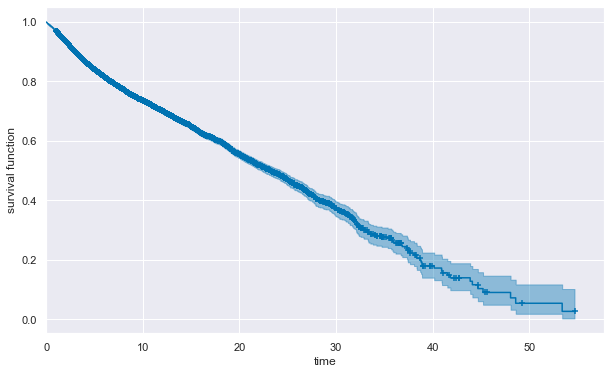

,time,events,at_risk,estimate,std_error,95%_CI_lower,95%_CI_upper
0,0.002738,4,23434,0.999829,0.000085,0.999545,0.999936
1,0.005476,1,23430,0.999787,0.000095,0.999487,0.999911
2,0.008214,3,23429,0.999659,0.000121,0.999317,0.999829
3,0.013689,1,23426,0.999616,0.000128,0.999262,0.999800
4,0.016427,1,23425,0.999573,0.000135,0.999207,0.999770


In [73]:
generate_kaplan_meier_for_status(survival_type="OS",years=1,save_to_csv_filename="None")